In [1]:
# !pip install geopandas
# !pip install pygeos
# !pip install rtree
# !pip install geopy

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiPoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy

/Users/sidd/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
def join_reducer(left, right):
    """
    Take two geodataframes, do a spatial join, and return 
    without the index_left and index_right columns
    """
    sjoin = gpd.sjoin(left, right, how='inner')
    for column in ['index_left', 'index_right']:
        try:
            sjoin.drop(column, axis=1, inplace=True)
        except Exception as e:
            # ignore if there are no index columns
            pass
    
    return sjoin

In [5]:
# Function to generate random points and lines on roads

# Source: https://github.com/gboeing/osmnx/issues/639

def sample_roads(geodf, n=100, isLine=False):
  '''
  Sample points and lines(street segments) from a road network
  '''
  m = len(geodf)
  lengths = geodf['LENGTH'].tolist()
  total_length = geodf.sum()['LENGTH']
  lengths_normalized = [l/total_length for l in lengths] 

  indices = np.random.choice(range(m), size=n, p=lengths_normalized)
  # indices = np.random.choice(range(m), size=n)

  if isLine:
    lines = []
    for index in indices:
      line = geodf.iloc[index]['geometry']
      lines.append(line)
  
    # return MultiPoint(lines)
    return gpd.GeoSeries(lines)
  
  points = []
  for index in indices:
      line = geodf.iloc[index]['geometry']
      offset = np.random.rand() * line.length
      point = line.interpolate(offset)
      points.append(point)
      
  # return MultiPoint(points)
  return gpd.GeoSeries(points)

In [6]:
def sample_location(geodf, n, buffer=None):
  '''
  Samples from a shapefile that has 
  ALL entries as point geometries
  '''
  m = len(geodf)
  indices = np.random.choice(range(m), size=n)
  sample = []

  for index in indices:
    point = geodf.iloc[index]['geometry']
    sample.append(point)

  output = gpd.GeoSeries(sample)
  if buffer:
    output.set_crs('EPSG:4326', inplace=True)
    output = output.to_crs(epsg=3763)
    output = output.buffer(buffer)
    output = output.to_crs(epsg=4326)
  return output

In [7]:
def reverse_geocode(geoseries, provider='arcgis'):
  '''
  Function to reverse geocode GeoSeries points
  '''
  return gpd.tools.reverse_geocode(list(geoseries), provider=provider)

In [8]:
def geoseries_to_geodf(geoseries):
  '''
  Converts a simple GeoSeries to a GeoPandas dataframe with a geometry column
  '''
  output_gdf = gpd.GeoDataFrame(geoseries)
  output_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
  return output_gdf

# Sample Points and Lines

## Road Network x County (Boundary)

In [9]:
fl_roads = gpd.read_file("./data/majrds_oct19/majrds_oct19.shp") # LINESTRING geometry
fl_roads = fl_roads.to_crs("EPSG:4326")

In [10]:
fl_counties = gpd.read_file("./data/cntbnd_sep15/cntbnd_sep15.shp") # POLYGON geometry
fl_counties = fl_counties.to_crs("EPSG:4326")

In [11]:
fl_hil = fl_counties[fl_counties['TIGERNAME'] == 'Hillsborough'] 

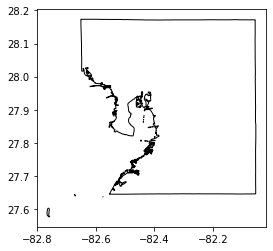

In [12]:
fl_hil.plot(facecolor="none", edgecolor="black")

In [ ]:
fl_roads_hil = join_reducer(fl_roads, fl_hil) # road network MUST be left parameter when joining

In [ ]:
sample_road_points = sample_roads(fl_roads_hil, n=10)

In [ ]:
reverse_geocode(sample_road_points)

In [ ]:
# ax = fl_hil.plot(figsize=(14,12), facecolor="none", edgecolor="black")
# fl_roads_hil.plot(ax=ax)
# sample_road_points.plot(marker='*', color='red', markersize=12, ax=ax)

In [ ]:
ax = fl_roads_hil.plot(figsize=(14, 12))
sample_road_points.plot(marker='*', color='red', markersize=15, ax=ax)

In [ ]:
sample_road_lines = sample_roads(fl_roads_hil, n=10, isLine=True)
sample_road_lines

In [ ]:
ax = fl_roads_hil.plot(figsize=(14, 12))
sample_road_lines.plot(color='red', ax=ax)

## Road Network x County x Parks & Rec (Boundary)

In [ ]:
fl_parks = gpd.read_file("./data/gc_parksbnd_oct19/gc_parksbnd_oct19.shp") # POLYGON geometry
fl_parks = fl_parks.to_crs("EPSG:4326")

In [ ]:
fl_parks.head()

In [ ]:
fl_parks.plot(figsize=(14, 12))

In [ ]:
fl_hil_parks = fl_parks[fl_parks['COUNTY'] == 'HILLSBOROUGH']

In [ ]:
fl_roads_hil_parks = join_reducer(fl_roads, fl_hil_parks)

In [ ]:
fl_roads_hil_parks.head()

In [ ]:
fl_roads_hil_parks.plot(figsize=(14,12))

In [ ]:
sample_park_points = sample_roads(fl_roads_hil_parks, n=5)

In [ ]:
ax = fl_roads_hil_parks.plot(figsize=(14, 12))
sample_park_points.plot(marker='*', color='red', markersize=12, ax=ax)

In [ ]:
sample_park_lines = sample_roads(fl_roads_hil_parks, n=5, isLine=True)

In [ ]:
ax = fl_roads_hil_parks.plot(figsize=(14, 12))
sample_park_lines.plot(color='red', markersize=10, ax=ax)

## Road Network x County x Hospital (Boundaries)

In [ ]:
fl_hosp = gpd.read_file("./data/gc_hospitalsbnd_sep17/gc_hospitalsbnd_sep17.shp") # POLYGON geometry
fl_hosp = fl_hosp.to_crs("EPSG:4326")

In [ ]:
fl_hosp.head()

In [ ]:
fl_hil_hosp = fl_hosp[fl_hosp['COUNTY']=='HILLSBOROUGH']

In [ ]:
fl_hil_hosp.plot(figsize=(14,12))

In [ ]:
fl_roads_hil_hosp = join_reducer(fl_roads, fl_hil_hosp)

In [ ]:
fl_roads_hil_hosp.plot(figsize=(14,12))

In [ ]:
sample_hosp_points = sample_roads(fl_roads_hil_hosp, n=5)
sample_hosp_points

In [ ]:
ax = fl_roads_hil_hosp.plot(figsize=(14, 12))
sample_hosp_points.plot(marker='*', color='red', markersize=12, ax=ax)

## Road Network x County x Civic Centers

In [ ]:
fl_civic = gpd.read_file("./data/gc_civiccenter_jan19/gc_civiccenter_jan19.shp")
fl_civic = fl_civic.to_crs("EPSG:4326")

In [ ]:
fl_civic.head()

In [ ]:
fl_civic.plot(figsize=(14,12))

In [ ]:
# Plotting multiple layers
fig, ax = plt.subplots(figsize=(14, 12))
fl_counties.plot(ax=ax, facecolor="none", edgecolor='black', column='NAME')
fl_civic.plot(ax=ax, color='blue')

In [ ]:
# https://gis.stackexchange.com/questions/367496/plot-a-circle-with-a-given-radius-around-points-on-map-using-python

In [ ]:
fl_civic_hil = join_reducer(fl_civic, fl_hil)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 12))
fl_counties.plot(ax=ax, facecolor="none", edgecolor='black', column='NAME')
fl_civic_hil.plot(ax=ax, color='blue')

In [ ]:
ax = fl_hil.plot(figsize=(20,18), facecolor="none", edgecolor="black")
fl_roads_hil.plot(ax=ax)
fl_civic_hil.plot(marker='*', color='red', markersize=15, ax=ax)

In [ ]:
sample_civic_region = sample_location(fl_civic_hil, n=2, buffer=8046.72) # buffer in meters (1 mi = 1609.34 m)

In [ ]:
ax = fl_hil.plot(figsize=(20,18), facecolor="none", edgecolor="black")
fl_roads_hil.plot(ax=ax)
sample_civic_region.plot(marker='*', color='red', ax=ax)

In [ ]:
sample_civic_df = gpd.GeoDataFrame(sample_civic_region)
sample_civic_df = sample_civic_df.rename(columns={0:'geometry'}).set_geometry('geometry')

In [ ]:
fl_roads_hil_sample_civic = join_reducer(fl_roads_hil, sample_civic_df)

In [ ]:
ax = fl_hil.plot(figsize=(20,18), facecolor="none", edgecolor="black")
fl_roads_hil_sample_civic.plot(ax=ax)
sample_civic_region.plot(marker='*', color='red', ax=ax)

In [ ]:
fl_roads_hil_sample_civic.plot(figsize=(14,12))

In [ ]:
sample_civic_points = sample_roads(fl_roads_hil_sample_civic, n=5)

In [ ]:
ax = fl_roads_hil_sample_civic.plot(figsize=(14, 12))
sample_civic_points.plot(marker='*', color='red', markersize=15, ax=ax)

In [ ]:
# https://gis.stackexchange.com/questions/344983/line-and-polygon-intersection-in-geopandas-python

# lines = streets.geometry.unary_union
# intersection = lines.intersection(buffer.geometry[0])
# type(intersection)
# <class 'shapely.geometry.multilinestring.MultiLineString'>
# # create a GeoDataFrame
# result = geopandas.GeoDataFrame({'geometry':intersection})

In [ ]:
lines = fl_roads_hil.geometry.unary_union
intersection = lines.intersection(sample_civic_df.geometry[0])
output = gpd.GeoDataFrame({'geometry':intersection})

In [ ]:
length_arr = []
for i in range(len(output)):
  len_i = output['geometry'][i].length
  length_arr.append(len_i)

output['LENGTH'] = length_arr

In [ ]:
output.plot(figsize=(14, 12))

In [ ]:
output_points = sample_roads(output, n=5)
ax = output.plot(figsize=(14, 12))
output_points.plot(marker='*', color='red', markersize=60, ax=ax)

In [ ]:
intersection_2 = lines.intersection(sample_civic_df.geometry[1])
output_2 = gpd.GeoDataFrame({'geometry':intersection_2})

In [ ]:
length_arr = []
for i in range(len(output_2)):
  len_i = output_2['geometry'][i].length
  length_arr.append(len_i)

output_2['LENGTH'] = length_arr

In [ ]:
output_2.plot(figsize=(14, 12))

In [ ]:
output_points_2 = sample_roads(output_2, n=3, isLine=True)
ax = output_2.plot(figsize=(14, 12))
output_points_2.plot(marker='*', color='red', markersize=60, ax=ax)